# Domain Modeling


In [728]:
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

In [729]:
domain_df = pd.read_csv("../../datasets/raw/cleaned/curated/domain_modelling.csv")
domain_df.columns

Index(['sa2_code', 'sa2_name', 'suburb', 'postcode', 'weekly_rent', 'bond',
       'address', 'lat', 'lon', 'bedrooms', 'bathrooms', 'carspaces',
       'property_type', 'balcony', 'car_parking', 'heating',
       'air_conditioning', 'builtin_wardrobes', 'swimming_pool', 'ensuite',
       'dishwasher', 'garden', 'gym', 'pets_allowed', 'gas', 'intercom',
       'security_system', 'washing_machine', 'property_type_grouped',
       'distance_supermarket_m', 'travel_time_supermarket_mins',
       'distance_train_station_m', 'travel_time_train_station_mins',
       'distance_school_m', 'travel_time_school_mins', 'distance_healthcare_m',
       'travel_time_healthcare_mins', 'distance_cbd_m', 'travel_time_cbd_mins',
       'crime_rate_sa2_2025', 'sa2_erp_2025',
       'sa2_pop_density_2025_people_per_km2', 'sa2_pop_growth_2020_2024',
       'sa2_median_historical_growth', 'sa2_erp_change_per_cent_2023_24',
       'sa2_median_income_cagr', 'sa2_predicted_median_income_25',
       'supermarket

In [730]:
cols_to_drop = ["sa2_code", "bond", "address", "sa2_name", "suburb", "postcode", "lat", "lon", "property_type"]
domain_v1 = domain_df.drop(columns=cols_to_drop)

## Baseline: Random forest and XGBoost

In [731]:
# Random forest baseline model 

X = domain_v1.drop(columns=["weekly_rent"])
y = domain_v1["weekly_rent"]

# Log-transform target
y_log = np.log1p(y)

# 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=27,
    stratify=X["property_type_grouped"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=27,
    stratify=X_temp["property_type_grouped"]
)

# One-hot encode property_type_grouped
X_train = pd.get_dummies(X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


# Train base XGB model 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate on train & val 
y_pred_val_log = rf.predict(X_val)
y_pred_train_log = rf.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

# Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

rf_final = RandomForestRegressor(**rf.get_params())
rf_final.fit(X_fulltrain, y_fulltrain)

# Evaluate final model on Test set 
y_pred_test_log = rf_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

Train R² (log): 0.962
Val   R² (log): 0.751
Test R² (log):  0.735
Test RMSE ($):  153.53


In [732]:
# XGBOOST BASELINE MODEL

X = domain_v1.drop(columns=["weekly_rent"])
y = domain_v1["weekly_rent"]

# Log-transform target
y_log = np.log1p(y)

# 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=27,
    stratify=X["property_type_grouped"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=27,
    stratify=X_temp["property_type_grouped"]
)

# One-hot encode property_type_grouped
X_train = pd.get_dummies(X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


# Train base XGB model 
xgb_model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=0.3,
    reg_lambda=1.0,
    gamma=0,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=100,
    verbose=True,
)

# Evaluate on train & val 
y_pred_val_log = xgb_model.predict(X_val)
y_pred_train_log = xgb_model.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

#  Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

xgb_final = XGBRegressor(**xgb_model.get_params())
xgb_final.fit(X_fulltrain, y_fulltrain, verbose=False)

#  Evaluate final model on Test set 
y_pred_test_log = xgb_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

[0]	validation_0-rmse:5.83915
[1]	validation_0-rmse:5.78098
[2]	validation_0-rmse:5.72336


/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:5.66628
[4]	validation_0-rmse:5.60977
[5]	validation_0-rmse:5.55382
[6]	validation_0-rmse:5.49849
[7]	validation_0-rmse:5.44382
[8]	validation_0-rmse:5.38966
[9]	validation_0-rmse:5.33604
[10]	validation_0-rmse:5.28293
[11]	validation_0-rmse:5.23036
[12]	validation_0-rmse:5.17821
[13]	validation_0-rmse:5.12657
[14]	validation_0-rmse:5.07545
[15]	validation_0-rmse:5.02502
[16]	validation_0-rmse:4.97503
[17]	validation_0-rmse:4.92545
[18]	validation_0-rmse:4.87648
[19]	validation_0-rmse:4.82799
[20]	validation_0-rmse:4.77997
[21]	validation_0-rmse:4.73245
[22]	validation_0-rmse:4.68528
[23]	validation_0-rmse:4.63872
[24]	validation_0-rmse:4.59251
[25]	validation_0-rmse:4.54679
[26]	validation_0-rmse:4.50151
[27]	validation_0-rmse:4.45669
[28]	validation_0-rmse:4.41228
[29]	validation_0-rmse:4.36844
[30]	validation_0-rmse:4.32495
[31]	validation_0-rmse:4.28199
[32]	validation_0-rmse:4.23941
[33]	validation_0-rmse:4.19721
[34]	validation_0-rmse:4.15540
[35]	validation

## Feature Selection

### Property level features correlation 

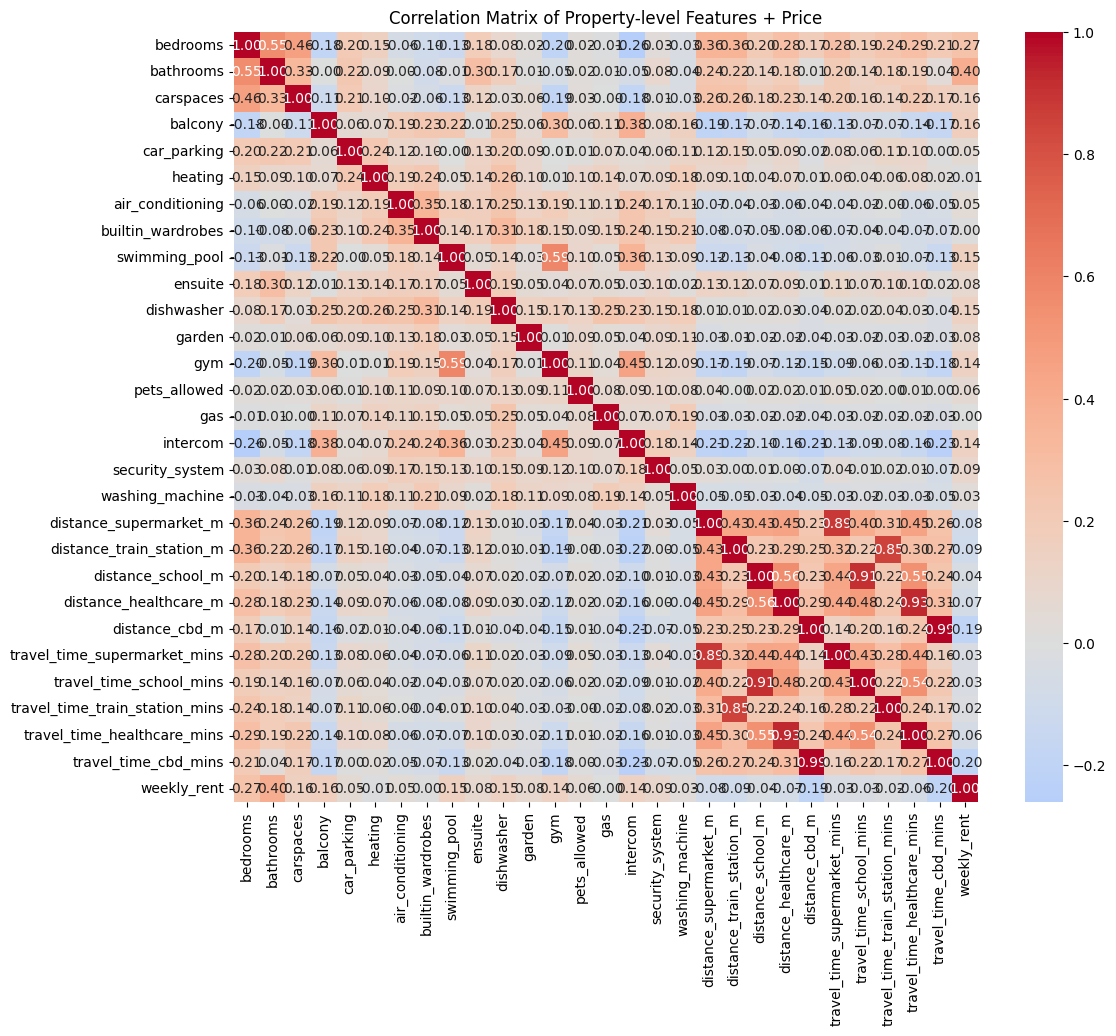

Correlation with price:
weekly_rent                       1.000000
bathrooms                         0.399163
bedrooms                          0.265825
balcony                           0.164459
carspaces                         0.157465
swimming_pool                     0.152804
dishwasher                        0.146164
gym                               0.142721
intercom                          0.135974
security_system                   0.086838
ensuite                           0.078249
garden                            0.075499
pets_allowed                      0.058895
car_parking                       0.051598
air_conditioning                  0.047227
washing_machine                   0.027809
builtin_wardrobes                 0.002769
gas                              -0.002247
heating                          -0.012221
travel_time_train_station_mins   -0.023406
travel_time_supermarket_mins     -0.029781
travel_time_school_mins          -0.030941
distance_school_m             

In [733]:
# property-level features and the target
features = ["bedrooms", "bathrooms", "carspaces", "balcony", "car_parking", "heating", "air_conditioning",
    "builtin_wardrobes", "swimming_pool", "ensuite", "dishwasher", "garden", "gym", "pets_allowed", "gas", "intercom", "security_system", "washing_machine",
    "distance_supermarket_m", "distance_train_station_m", "distance_school_m", "distance_healthcare_m",
    "distance_cbd_m", "travel_time_supermarket_mins", "travel_time_school_mins", "travel_time_train_station_mins",
    "travel_time_healthcare_mins", "travel_time_cbd_mins"]

target = "weekly_rent"

# dataframe including target
corr_df = domain_v1[features + [target]]

# Compute the correlation matrix
corr_matrix = corr_df.corr()

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Property-level Features + Price")
plt.show()

# print correlation of each feature with target
print("Correlation with price:")
print(corr_matrix[target].sort_values(ascending=False))

In [734]:
high_corr_pairs = [
    (i, j, corr_matrix.loc[i, j])
    for i in corr_matrix.columns
    for j in corr_matrix.columns
    if i != j and abs(corr_matrix.loc[i, j]) > 0.7
]

for i, j, val in high_corr_pairs:
    print(f"{i} — {j}: {val:.2f}")

distance_supermarket_m — travel_time_supermarket_mins: 0.89
distance_train_station_m — travel_time_train_station_mins: 0.85
distance_school_m — travel_time_school_mins: 0.91
distance_healthcare_m — travel_time_healthcare_mins: 0.93
distance_cbd_m — travel_time_cbd_mins: 0.99
travel_time_supermarket_mins — distance_supermarket_m: 0.89
travel_time_school_mins — distance_school_m: 0.91
travel_time_train_station_mins — distance_train_station_m: 0.85
travel_time_healthcare_mins — distance_healthcare_m: 0.93
travel_time_cbd_mins — distance_cbd_m: 0.99


In [735]:
amenities = ["supermarket", "train_station", "school", "healthcare", "cbd"]
keep_cols = []

for a in amenities:
    dist_col = f"distance_{a}_m"
    time_col = f"travel_time_{a}_mins"

    dist_corr = abs(domain_v1[dist_col].corr(domain_df["weekly_rent"]))
    time_corr = abs(domain_v1[time_col].corr(domain_df["weekly_rent"]))

    if dist_corr >= time_corr:
        keep_cols.append(dist_col)
    else:
        keep_cols.append(time_col)

print("Keep these columns based on higher correlation with price:")
print(keep_cols)

Keep these columns based on higher correlation with price:
['distance_supermarket_m', 'distance_train_station_m', 'distance_school_m', 'distance_healthcare_m', 'travel_time_cbd_mins']


In [736]:
drop_cols = [
    "travel_time_supermarket_mins",
    "travel_time_train_station_mins",
    "travel_time_school_mins",
    "travel_time_healthcare_mins",
    "distance_cbd_m"]
domain_df_v2 = domain_v1.drop(columns=drop_cols)

### SA2 context features


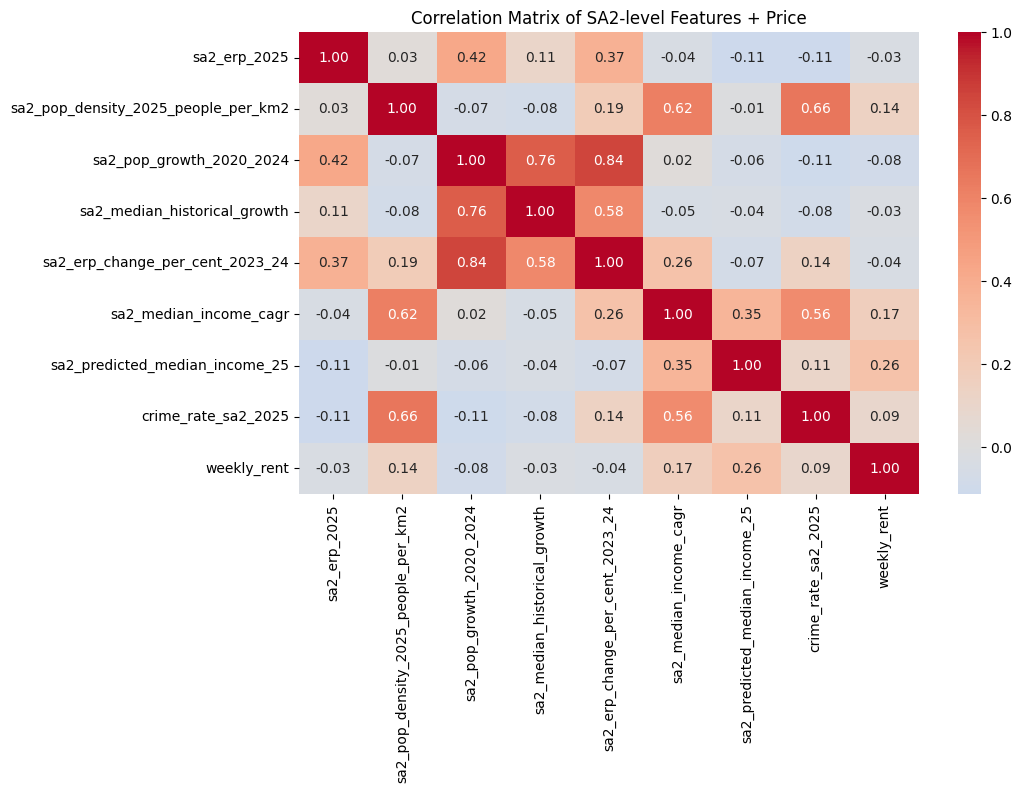

Correlation of SA2-level features with price:
weekly_rent                            1.000000
sa2_predicted_median_income_25         0.262789
sa2_median_income_cagr                 0.167535
sa2_pop_density_2025_people_per_km2    0.142527
crime_rate_sa2_2025                    0.094388
sa2_median_historical_growth          -0.026955
sa2_erp_2025                          -0.031012
sa2_erp_change_per_cent_2023_24       -0.039660
sa2_pop_growth_2020_2024              -0.084206
Name: weekly_rent, dtype: float64


In [737]:
# SA2-level features
sa2_features = [
    "sa2_erp_2025",
    "sa2_pop_density_2025_people_per_km2",
    "sa2_pop_growth_2020_2024",
    "sa2_median_historical_growth",
    "sa2_erp_change_per_cent_2023_24",
    "sa2_median_income_cagr",
    "sa2_predicted_median_income_25",
    "crime_rate_sa2_2025",
]

# Include target
corr_df_sa2 = domain_df_v2[sa2_features + [target]]

# Correlation matrix
corr_matrix_sa2 = corr_df_sa2.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_sa2, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of SA2-level Features + Price")
plt.show()

# Print correlation with target
print("Correlation of SA2-level features with price:")
print(corr_matrix_sa2[target].sort_values(ascending=False))

In [738]:
high_corr_pairs = [
    (i, j, corr_matrix_sa2.loc[i, j])
    for i in corr_matrix_sa2.columns
    for j in corr_matrix_sa2.columns
    if i != j and abs(corr_matrix_sa2.loc[i, j]) > 0.6
]

for i, j, val in high_corr_pairs:
    print(f"{i} — {j}: {val:.2f}")

sa2_pop_density_2025_people_per_km2 — sa2_median_income_cagr: 0.62
sa2_pop_density_2025_people_per_km2 — crime_rate_sa2_2025: 0.66
sa2_pop_growth_2020_2024 — sa2_median_historical_growth: 0.76
sa2_pop_growth_2020_2024 — sa2_erp_change_per_cent_2023_24: 0.84
sa2_median_historical_growth — sa2_pop_growth_2020_2024: 0.76
sa2_erp_change_per_cent_2023_24 — sa2_pop_growth_2020_2024: 0.84
sa2_median_income_cagr — sa2_pop_density_2025_people_per_km2: 0.62
crime_rate_sa2_2025 — sa2_pop_density_2025_people_per_km2: 0.66


In [739]:
# List of SA2-level features
sa2_features = [
    "sa2_erp_2025",
    "sa2_pop_density_2025_people_per_km2",
    "sa2_pop_growth_2020_2024",
    "sa2_median_historical_growth",
    "sa2_erp_change_per_cent_2023_24",
    "sa2_median_income_cagr",
    "sa2_predicted_median_income_25",
    "crime_rate_sa2_2025",
]

# Compute correlation matrix for SA2 features
corr_matrix_sa2 = domain_df_v2[sa2_features + ["weekly_rent"]].corr()

# Correlation with target
corr_with_target = corr_matrix_sa2["weekly_rent"].abs()

# Threshold for high correlation
threshold = 0.7

# Find highly correlated pairs (excluding self-correlation)
high_corr_pairs = [
    (i, j, corr_matrix_sa2.loc[i, j])
    for i in sa2_features
    for j in sa2_features
    if i != j and abs(corr_matrix_sa2.loc[i, j]) > threshold
]

# Keep track of dropped features
dropped_features = set()

for i, j, val in high_corr_pairs:
    if i in dropped_features or j in dropped_features:
        continue
    # Compare correlation with target and drop the lower one
    if corr_with_target[i] < corr_with_target[j]:
        dropped_features.add(i)
    else:
        dropped_features.add(j)

print("SA2 features to drop due to high correlation:", dropped_features)

# Drop from DataFrame
domain_df_v2 = domain_df_v2.drop(columns=list(dropped_features))

SA2 features to drop due to high correlation: {'sa2_median_historical_growth', 'sa2_erp_change_per_cent_2023_24'}


In [742]:
domain_df_v2.columns

Index(['weekly_rent', 'bedrooms', 'bathrooms', 'carspaces', 'balcony',
       'car_parking', 'heating', 'air_conditioning', 'builtin_wardrobes',
       'swimming_pool', 'ensuite', 'dishwasher', 'garden', 'gym',
       'pets_allowed', 'gas', 'intercom', 'security_system', 'washing_machine',
       'property_type_grouped', 'distance_supermarket_m',
       'distance_train_station_m', 'distance_school_m',
       'distance_healthcare_m', 'travel_time_cbd_mins', 'crime_rate_sa2_2025',
       'sa2_erp_2025', 'sa2_pop_density_2025_people_per_km2',
       'sa2_pop_growth_2020_2024', 'sa2_median_income_cagr',
       'sa2_predicted_median_income_25', 'supermarket_nearby',
       'train_station_nearby', 'school_nearby', 'healthcare_nearby'],
      dtype='object')

### Retrain on new set


### Random Forest

In [746]:
# Prepare data
X = domain_df_v2.drop(columns=["weekly_rent"])
y = domain_df_v2["weekly_rent"]

# Log-transform target
y_log = np.log1p(y)

# 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=27,
    stratify=X["property_type_grouped"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=27,
    stratify=X_temp["property_type_grouped"]
)

# One-hot encode property_type_grouped
X_train = pd.get_dummies(X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train base XGB model 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate on train & val 
y_pred_val_log = rf.predict(X_val)
y_pred_train_log = rf.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

# Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

rf_final = RandomForestRegressor(**rf.get_params())
rf_final.fit(X_fulltrain, y_fulltrain)

# Evaluate final model on Test set 
y_pred_test_log = rf_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

Train R² (log): 0.963
Val   R² (log): 0.751
Test R² (log):  0.740
Test RMSE ($):  152.25


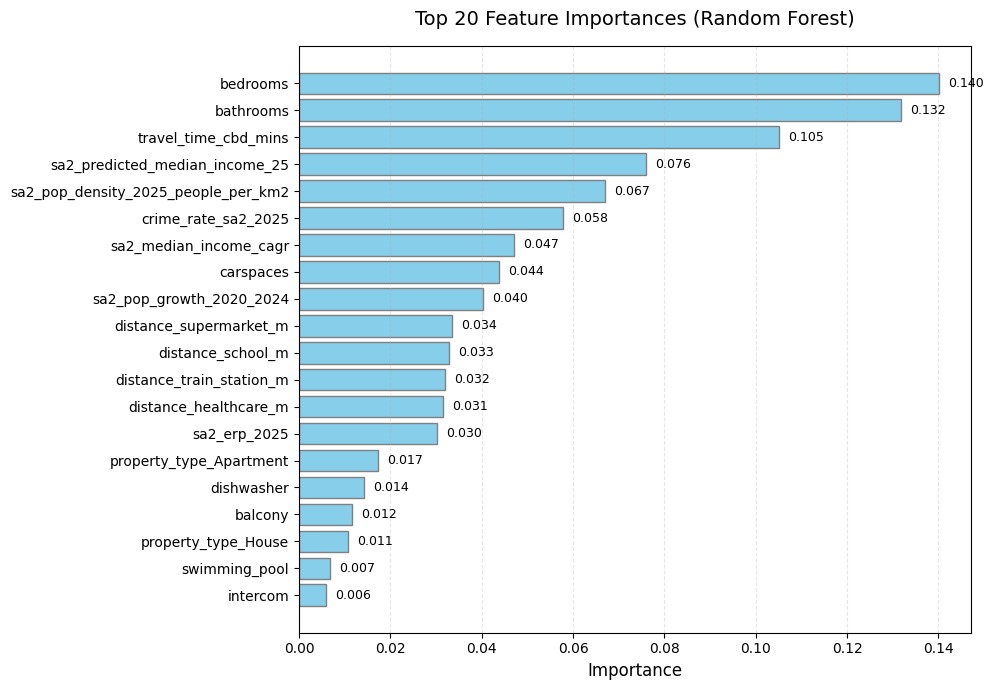

In [ ]:
feature_names = X_fulltrain.columns  
importances = rf_final.feature_importances_


feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(20)


plt.figure(figsize=(10, 7))
bars = plt.barh(
    y=np.arange(len(feat_imp_df)), 
    width=feat_imp_df["importance"], 
    color="skyblue", 
    edgecolor="gray"
)

plt.yticks(np.arange(len(feat_imp_df)), feat_imp_df["feature"], fontsize=10)
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=14, pad=15)
plt.xlabel("Importance", fontsize=12)
plt.grid(alpha=0.3, linestyle="--", axis="x")

for i, v in enumerate(feat_imp_df["importance"]):
    plt.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()



### XGBoost 

In [749]:
# Split data
X = domain_df_v2.drop(columns=["weekly_rent"])
y = domain_df_v2["weekly_rent"]

y_log = np.log1p(y)

# Split with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=27, stratify=X["property_type_grouped"]
)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=27, stratify=X_temp["property_type_grouped"],)

# One-hot encode property_type_grouped
X_train = pd.get_dummies(X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


# Train base XGB model 
xgb_model = XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=8, min_child_weight=5,  subsample=0.8, colsample_bytree=0.6, reg_alpha=0.3,  reg_lambda=1.0,
    gamma=0, random_state=42, n_jobs=-1,)


xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=True,
)

# Evaluate on train & val 
y_pred_val_log = xgb_model.predict(X_val)
y_pred_train_log = xgb_model.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

#  Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

xgb_final = XGBRegressor(**xgb_model.get_params())
xgb_final.fit(X_fulltrain, y_fulltrain, verbose=False)

#  Evaluate final model on Test set 
y_pred_test_log = xgb_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

[0]	validation_0-rmse:5.83914
[1]	validation_0-rmse:5.78094
[2]	validation_0-rmse:5.72327
[3]	validation_0-rmse:5.66629
[4]	validation_0-rmse:5.60979
[5]	validation_0-rmse:5.55390
[6]	validation_0-rmse:5.49856
[7]	validation_0-rmse:5.44374
[8]	validation_0-rmse:5.38951
[9]	validation_0-rmse:5.33589
[10]	validation_0-rmse:5.28282
[11]	validation_0-rmse:5.23025
[12]	validation_0-rmse:5.17813
[13]	validation_0-rmse:5.12653
[14]	validation_0-rmse:5.07550
[15]	validation_0-rmse:5.02504
[16]	validation_0-rmse:4.97507
[17]	validation_0-rmse:4.92561
[18]	validation_0-rmse:4.87653
[19]	validation_0-rmse:4.82792
[20]	validation_0-rmse:4.77985
[21]	validation_0-rmse:4.73228
[22]	validation_0-rmse:4.68526
[23]	validation_0-rmse:4.63869
[24]	validation_0-rmse:4.59250
[25]	validation_0-rmse:4.54684
[26]	validation_0-rmse:4.50161
[27]	validation_0-rmse:4.45683
[28]	validation_0-rmse:4.41251
[29]	validation_0-rmse:4.36862
[30]	validation_0-rmse:4.32517
[31]	validation_0-rmse:4.28210
[32]	validation_0-

/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-rmse:2.98975
[68]	validation_0-rmse:2.96003
[69]	validation_0-rmse:2.93073
[70]	validation_0-rmse:2.90166
[71]	validation_0-rmse:2.87297
[72]	validation_0-rmse:2.84456
[73]	validation_0-rmse:2.81636
[74]	validation_0-rmse:2.78851
[75]	validation_0-rmse:2.76092
[76]	validation_0-rmse:2.73358
[77]	validation_0-rmse:2.70658
[78]	validation_0-rmse:2.67978
[79]	validation_0-rmse:2.65324
[80]	validation_0-rmse:2.62700
[81]	validation_0-rmse:2.60099
[82]	validation_0-rmse:2.57528
[83]	validation_0-rmse:2.54985
[84]	validation_0-rmse:2.52465
[85]	validation_0-rmse:2.49967
[86]	validation_0-rmse:2.47498
[87]	validation_0-rmse:2.45051
[88]	validation_0-rmse:2.42634
[89]	validation_0-rmse:2.40242
[90]	validation_0-rmse:2.37869
[91]	validation_0-rmse:2.35520
[92]	validation_0-rmse:2.33200
[93]	validation_0-rmse:2.30900
[94]	validation_0-rmse:2.28618
[95]	validation_0-rmse:2.26363
[96]	validation_0-rmse:2.24134
[97]	validation_0-rmse:2.21930
[98]	validation_0-rmse:2.19737
[99]	val

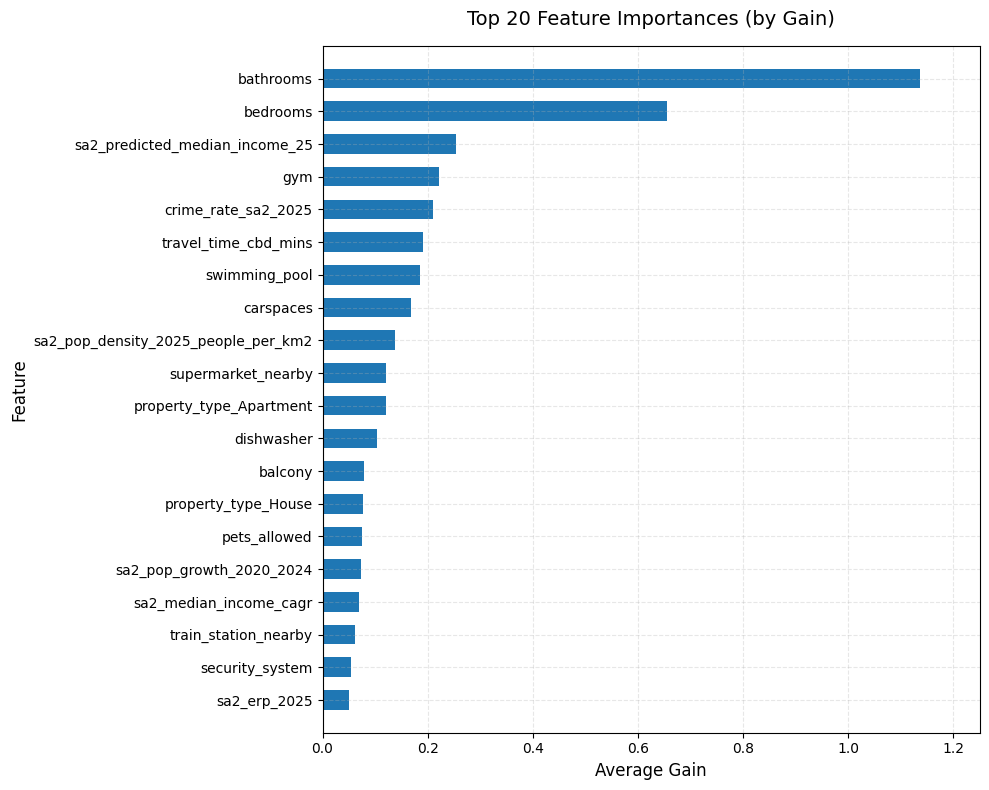

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))

# Plot top 20 features by gain
plot_importance(
    xgb_final, 
    ax=ax, 
    max_num_features=20, 
    importance_type="gain", 
    height=0.6, 
    show_values=False  
)


ax.set_title("Top 20 Feature Importances (by Gain)", fontsize=14, pad=15)
ax.set_xlabel("Average Gain", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.grid(alpha=0.3, linestyle="--")

for label in ax.get_yticklabels():
    label.set_fontsize(10)

plt.tight_layout()
plt.show()

## try including interactions


In [751]:
domain_df_v2.head()

,weekly_rent,bedrooms,bathrooms,carspaces,balcony,car_parking,heating,air_conditioning,builtin_wardrobes,swimming_pool,...,crime_rate_sa2_2025,sa2_erp_2025,sa2_pop_density_2025_people_per_km2,sa2_pop_growth_2020_2024,sa2_median_income_cagr,sa2_predicted_median_income_25,supermarket_nearby,train_station_nearby,school_nearby,healthcare_nearby
0,460.0,2,1,2,0,1,1,0,1,0,...,6491.46985,20138.014352,2277.875547,2.724838,3.920093,85258.92381,1,1,1,1
1,400.0,2,1,1,0,0,1,0,0,0,...,6491.46985,20138.014352,2277.875547,2.724838,3.920093,85258.92381,1,1,1,1
2,795.0,3,2,3,1,0,1,1,1,0,...,6491.46985,16287.171760,1006.350051,3.364510,4.220320,70070.10476,1,1,1,1
3,675.0,3,1,2,1,1,1,1,1,0,...,6491.46985,20138.014352,2277.875547,2.724838,3.920093,85258.92381,1,1,1,1
4,450.0,2,1,0,0,0,1,0,1,0,...,6491.46985,20138.014352,2277.875547,2.724838,3.920093,85258.92381,1,1,1,1


### Random Forest 

In [752]:
# Prepare data
X = domain_df_v2.drop(columns=["weekly_rent"])
y = domain_df_v2["weekly_rent"]

# Log-transform target
y_log = np.log1p(y)

# 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=27,
    stratify=X["property_type_grouped"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=27,
    stratify=X_temp["property_type_grouped"]
)

# One-hot encode property_type_grouped
X_train = pd.get_dummies(X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# try interaction
X_train["bed_bath"] = X_train["bedrooms"] * X_train["bathrooms"]
X_val["bed_bath"]   = X_val["bedrooms"]   * X_val["bathrooms"]
X_test["bed_bath"]  = X_test["bedrooms"]  * X_test["bathrooms"]

# Train base XGB model 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate on train & val 
y_pred_val_log = rf.predict(X_val)
y_pred_train_log = rf.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

# Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

rf_final = RandomForestRegressor(**rf.get_params())
rf_final.fit(X_fulltrain, y_fulltrain)

# Evaluate final model on Test set 
y_pred_test_log = rf_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

Train R² (log): 0.964
Val   R² (log): 0.752
Test R² (log):  0.741
Test RMSE ($):  151.17


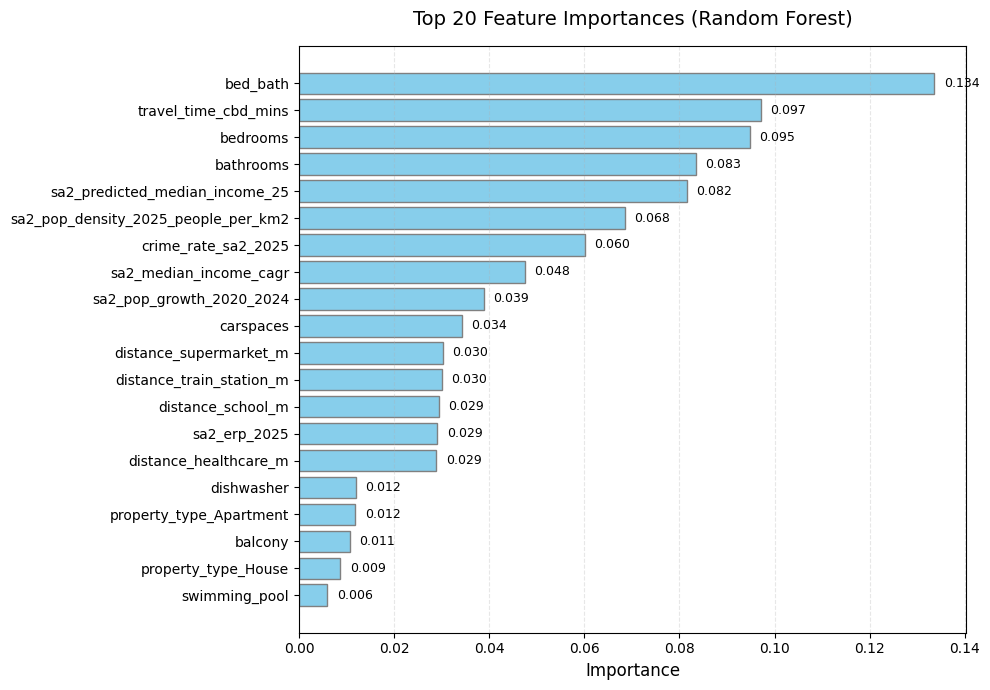

In [ ]:

feature_names = X_fulltrain.columns  
importances = rf_final.feature_importances_

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 7))
bars = plt.barh(
    y=np.arange(len(feat_imp_df)), 
    width=feat_imp_df["importance"], 
    color="skyblue", 
    edgecolor="gray"
)

plt.yticks(np.arange(len(feat_imp_df)), feat_imp_df["feature"], fontsize=10)
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=14, pad=15)
plt.xlabel("Importance", fontsize=12)
plt.grid(alpha=0.3, linestyle="--", axis="x")

for i, v in enumerate(feat_imp_df["importance"]):
    plt.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [753]:
# Split data
X = domain_df_v2.drop(columns=["weekly_rent"])
y = domain_df_v2["weekly_rent"]

y_log = np.log1p(y)

# Split with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.2, random_state=27, stratify=X["property_type_grouped"])
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp, test_size=0.25, random_state=27, stratify=X_temp["property_type_grouped"])

# One-hot encode property_type_grouped
X_train = pd.get_dummies( X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# try interaction
X_train["bed_bath"] = X_train["bedrooms"] * X_train["bathrooms"]
X_val["bed_bath"]   = X_val["bedrooms"]   * X_val["bathrooms"]
X_test["bed_bath"]  = X_test["bedrooms"]  * X_test["bathrooms"]


xgb_model = XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=8, min_child_weight=5,  subsample=0.8, colsample_bytree=0.6, reg_alpha=0.3,  reg_lambda=1.0,
    gamma=0, random_state=42, n_jobs=-1,)


xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=True,
)

# Evaluate on train & val 
y_pred_val_log = xgb_model.predict(X_val)
y_pred_train_log = xgb_model.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

#  Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

xgb_final = XGBRegressor(**xgb_model.get_params())
xgb_final.fit(X_fulltrain, y_fulltrain, verbose=False)

#  Evaluate final model on Test set 
y_pred_test_log = xgb_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

[0]	validation_0-rmse:5.83901
[1]	validation_0-rmse:5.78082
[2]	validation_0-rmse:5.72315
[3]	validation_0-rmse:5.66611
[4]	validation_0-rmse:5.60971
[5]	validation_0-rmse:5.55383
[6]	validation_0-rmse:5.49845
[7]	validation_0-rmse:5.44363
[8]	validation_0-rmse:5.38936
[9]	validation_0-rmse:5.33567
[10]	validation_0-rmse:5.28247
[11]	validation_0-rmse:5.22978
[12]	validation_0-rmse:5.17766
[13]	validation_0-rmse:5.12608
[14]	validation_0-rmse:5.07501
[15]	validation_0-rmse:5.02450
[16]	validation_0-rmse:4.97447


/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:4.92489
[18]	validation_0-rmse:4.87582
[19]	validation_0-rmse:4.82722
[20]	validation_0-rmse:4.77914
[21]	validation_0-rmse:4.73153
[22]	validation_0-rmse:4.68438
[23]	validation_0-rmse:4.63775
[24]	validation_0-rmse:4.59165
[25]	validation_0-rmse:4.54600
[26]	validation_0-rmse:4.50078
[27]	validation_0-rmse:4.45601
[28]	validation_0-rmse:4.41164
[29]	validation_0-rmse:4.36779
[30]	validation_0-rmse:4.32432
[31]	validation_0-rmse:4.28131
[32]	validation_0-rmse:4.23871
[33]	validation_0-rmse:4.19659
[34]	validation_0-rmse:4.15486
[35]	validation_0-rmse:4.11362
[36]	validation_0-rmse:4.07272
[37]	validation_0-rmse:4.03219
[38]	validation_0-rmse:3.99206
[39]	validation_0-rmse:3.95238
[40]	validation_0-rmse:3.91304
[41]	validation_0-rmse:3.87417
[42]	validation_0-rmse:3.83568
[43]	validation_0-rmse:3.79755
[44]	validation_0-rmse:3.75982
[45]	validation_0-rmse:3.72254
[46]	validation_0-rmse:3.68553
[47]	validation_0-rmse:3.64895
[48]	validation_0-rmse:3.61275
[49]	val

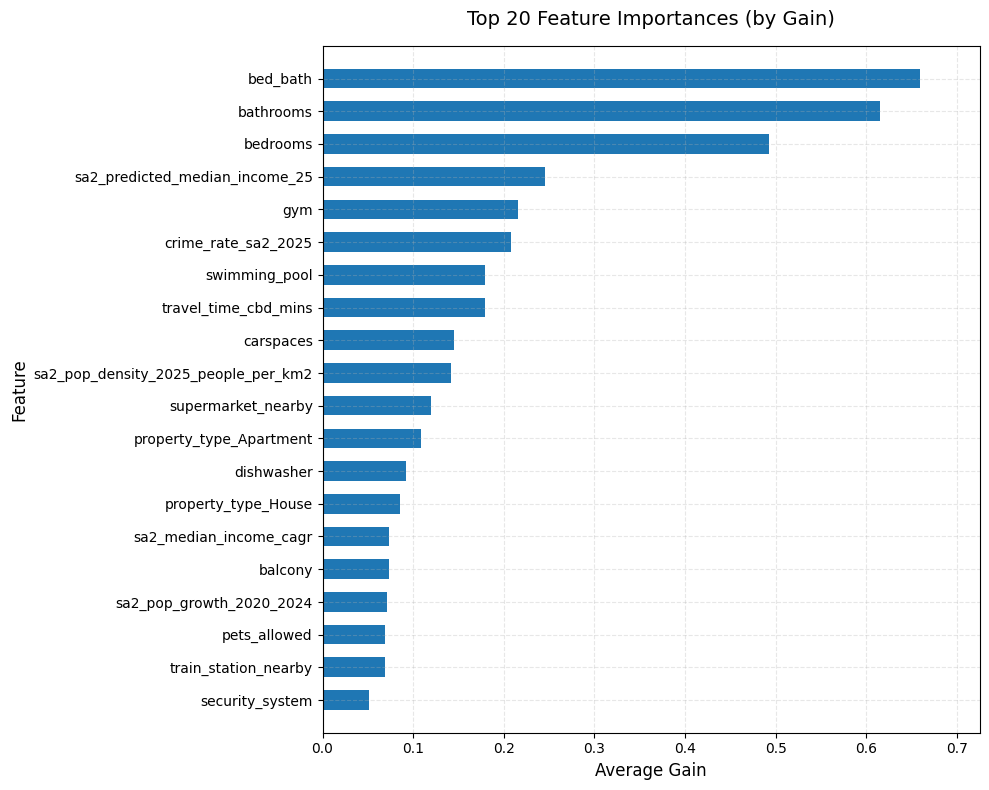

In [754]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Create a larger and clearer figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot top 20 features by gain
plot_importance(
    xgb_final, 
    ax=ax, 
    max_num_features=20, 
    importance_type="gain", 
    height=0.6, 
    show_values=False  
)

# Make the chart look cleaner
ax.set_title("Top 20 Feature Importances (by Gain)", fontsize=14, pad=15)
ax.set_xlabel("Average Gain", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.grid(alpha=0.3, linestyle="--")

# Increase font size for y-axis labels
for label in ax.get_yticklabels():
    label.set_fontsize(10)

plt.tight_layout()
plt.show()

In [568]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define model
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.03,
    random_state=42,
    n_jobs=-1
)

# Define parameter grid
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.3, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
}

# Define search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=60,  # you can increase to 100 for more thorough search
    scoring=make_scorer(r2_score),
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on train + validation set (log-transformed target)
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

random_search.fit(X_tune, y_tune)

print("Best CV R²:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=6, min_child_weight=10, reg_alpha=0.3, reg_lambda=2.0, subsample=0.9; total time=  21.7s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=6, min_child_weight=10, reg_alpha=0.3, reg_lambda=2.0, subsample=0.9; total time=  22.0s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=6, min_child_weight=10, reg_alpha=0.3, reg_lambda=2.0, subsample=0.9; total time=  22.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=10, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=  30.9s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=10, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=  31.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=8, min_child_weight=7, reg_alpha=0.5, reg_lambda=1.0, subsamp

In [635]:
# Final model using tuned parameters 
best_params = {
    'subsample': 0.8,
    'reg_lambda': 1.0,
    'reg_alpha': 0.3,
    'min_child_weight': 5,
    'max_depth': 8,
    'learning_rate': 0.01,
    'gamma': 0,
    'colsample_bytree': 0.6,
    'n_estimators': 3000,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
}

xgb_final = XGBRegressor(**best_params)

# Combine training + validation
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

# Fit with early stopping on val set (optional)
xgb_final.fit(
    X_fulltrain, y_fulltrain,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=200,
    verbose=True
)

#  Evaluate on test set 
y_pred_test_log = xgb_final.predict(X_test)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

# Metrics
test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")


[0]	validation_0-rmse:5.83900
[1]	validation_0-rmse:5.78088
[2]	validation_0-rmse:5.72320
[3]	validation_0-rmse:5.66618
[4]	validation_0-rmse:5.60967
[5]	validation_0-rmse:5.55369
[6]	validation_0-rmse:5.49837
[7]	validation_0-rmse:5.44357
[8]	validation_0-rmse:5.38930
[9]	validation_0-rmse:5.33562
[10]	validation_0-rmse:5.28246
[11]	validation_0-rmse:5.22983
[12]	validation_0-rmse:5.17775
[13]	validation_0-rmse:5.12616
[14]	validation_0-rmse:5.07507
[15]	validation_0-rmse:5.02451
[16]	validation_0-rmse:4.97445
[17]	validation_0-rmse:4.92494
[18]	validation_0-rmse:4.87584
[19]	validation_0-rmse:4.82728
[20]	validation_0-rmse:4.77921
[21]	validation_0-rmse:4.73157
[22]	validation_0-rmse:4.68444
[23]	validation_0-rmse:4.63780
[24]	validation_0-rmse:4.59160
[25]	validation_0-rmse:4.54587
[26]	validation_0-rmse:4.50064
[27]	validation_0-rmse:4.45589
[28]	validation_0-rmse:4.41158
[29]	validation_0-rmse:4.36768
[30]	validation_0-rmse:4.32418
[31]	validation_0-rmse:4.28117
[32]	validation_0-

/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[58]	validation_0-rmse:3.26896
[59]	validation_0-rmse:3.23646
[60]	validation_0-rmse:3.20435
[61]	validation_0-rmse:3.17260
[62]	validation_0-rmse:3.14115
[63]	validation_0-rmse:3.11001
[64]	validation_0-rmse:3.07920
[65]	validation_0-rmse:3.04867
[66]	validation_0-rmse:3.01844
[67]	validation_0-rmse:2.98851
[68]	validation_0-rmse:2.95883
[69]	validation_0-rmse:2.92948
[70]	validation_0-rmse:2.90049
[71]	validation_0-rmse:2.87171
[72]	validation_0-rmse:2.84328
[73]	validation_0-rmse:2.81512
[74]	validation_0-rmse:2.78724
[75]	validation_0-rmse:2.75961
[76]	validation_0-rmse:2.73230
[77]	validation_0-rmse:2.70524
[78]	validation_0-rmse:2.67848
[79]	validation_0-rmse:2.65197
[80]	validation_0-rmse:2.62569
[81]	validation_0-rmse:2.59967
[82]	validation_0-rmse:2.57391
[83]	validation_0-rmse:2.54845
[84]	validation_0-rmse:2.52325
[85]	validation_0-rmse:2.49829
[86]	validation_0-rmse:2.47358
[87]	validation_0-rmse:2.44909
[88]	validation_0-rmse:2.42489
[89]	validation_0-rmse:2.40095
[90]	val

### Diagonistic plots xgboost

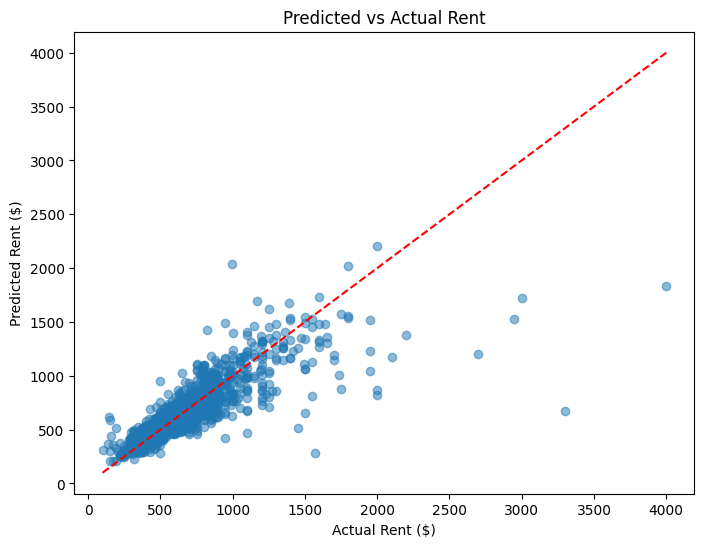

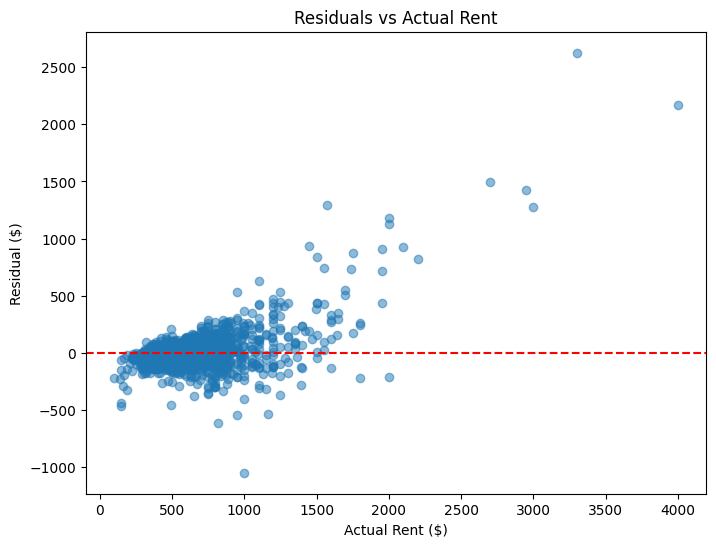

Residuals summary:
count    2524.000000
mean        6.825739
std       143.218565
min     -1046.956421
25%       -41.572052
50%        -3.905396
75%        35.048965
max      2625.364502
Name: weekly_rent, dtype: float64


In [755]:
import matplotlib.pyplot as plt
import numpy as np

# Predicted and actual rents in real dollars
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_test_log)

# Residuals
residuals = y_test_real - y_pred_real

# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Actual Rent ($)")
plt.ylabel("Predicted Rent ($)")
plt.title("Predicted vs Actual Rent")
plt.show()

# Residuals vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Rent ($)")
plt.ylabel("Residual ($)")
plt.title("Residuals vs Actual Rent")
plt.show()

# Optional: summary stats
print("Residuals summary:")
print(pd.Series(residuals).describe())


Note: Model performs well on typical rent ranges but struggles with expensive properties(tends to underpredict high rents)

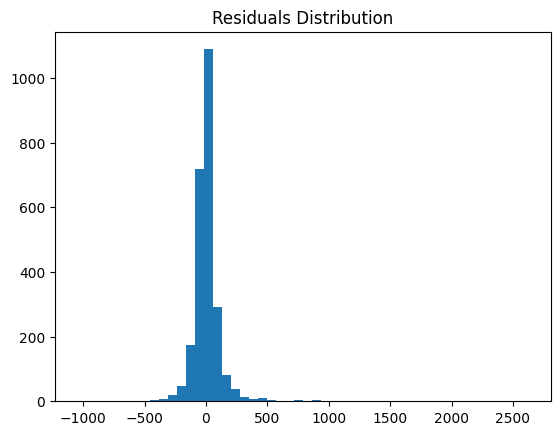

In [637]:
import matplotlib.pyplot as plt
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.show()

Most residuals cluster around 0 for low rents, heteroscedasticity as actual rent increases

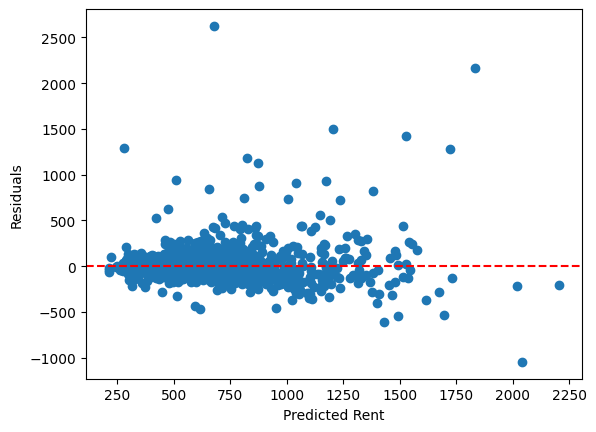

In [638]:
# Patterns of error vs prediction: bias, heteroscedasticity, and extreme value
plt.scatter(y_pred_test_real, residuals)
plt.xlabel("Predicted Rent")
plt.ylabel("Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.show()

# produce prediction

In [661]:
# Prepare full dataset 
X_full = domain_df_v2.drop(columns=["weekly_rent"])
y_full = np.log1p(domain_df_v2["weekly_rent"])  

#  Feature engineering
X_full["bed_bath"] = X_full["bedrooms"] * X_full["bathrooms"]

# One-hot encode categorical variable 
X_full = pd.get_dummies(X_full, columns=["property_type_grouped"], prefix="property_type")

best_params = {
    'subsample': 0.8,
    'reg_lambda': 1.0,
    'reg_alpha': 0.3,
    'min_child_weight': 5,
    'max_depth': 8,
    'learning_rate': 0.01,
    'gamma': 0,
    'colsample_bytree': 0.6,
    'n_estimators': 3000,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
}

# Train final XGB model on full domain
xgb_final_full = XGBRegressor(**best_params)
xgb_final_full.fit(X_full, y_full, verbose=True) 

# Predict baseline rents 
y_pred_log_full = xgb_final_full.predict(X_full)
y_pred_real_full = np.expm1(y_pred_log_full)  


domain_df["predicted_weekly_rent"] = y_pred_real_full

# Quick check
print(domain_df[["weekly_rent", "predicted_weekly_rent"]].head())


   weekly_rent  predicted_weekly_rent
0        460.0             485.532898
1        400.0             449.437561
2        795.0             795.881165
3        675.0             656.813599
4        450.0             457.739655


In [662]:
domain_df.head()

,sa2_code,sa2_name,suburb,postcode,weekly_rent,bond,address,lat,lon,bedrooms,...,sa2_pop_growth_2020_2024,sa2_median_historical_growth,sa2_erp_change_per_cent_2023_24,sa2_median_income_cagr,sa2_predicted_median_income_25,supermarket_nearby,train_station_nearby,school_nearby,healthcare_nearby,predicted_weekly_rent
0,213021344,Newport,SOUTH KINGSVILLE,3015,460.0,1994.0,3/53 Greene Street,-37.830982,144.87091,2,...,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1,485.532898
1,213021344,Newport,SOUTH KINGSVILLE,3015,400.0,1738.0,1/3 New Street,-37.826218,144.86755,2,...,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1,449.437561
2,213021343,Altona North,SOUTH KINGSVILLE,3015,795.0,3454.0,19/92 New Street,-37.831226,144.86632,3,...,3.364510,4.702436,3.4317,4.220320,70070.10476,1,1,1,1,795.881165
3,213021344,Newport,SOUTH KINGSVILLE,3015,675.0,2933.0,3/14 Saltley Street,-37.827423,144.86768,3,...,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1,656.813599
4,213021344,Newport,SOUTH KINGSVILLE,3015,450.0,1955.0,4/2B Saltley Street,-37.826270,144.86790,2,...,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1,457.739655


In [666]:
domain_df.to_csv("../../datasets/results/baseline_rent_predictions_2025.csv", index=False)

### linear models

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1️⃣ Scale continuous features for linear models and SVR
continuous_features = ["distance_supermarket_m", "distance_train_station_m", "distance_school_m",
                       "distance_healthcare_m", "travel_time_cbd_mins", "bedrooms", "bathrooms",
                       "carspaces", "crime_rate_sa2_2025", "sa2_erp_2025", "sa2_pop_density_2025_people_per_km2",
                       "sa2_pop_growth_2020_2024", "sa2_predicted_median_income_25"]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

# 2 Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42, max_iter=10000),
    "SVR": SVR(kernel="rbf", C=10, epsilon=0.1)
}

# Train & evaluate
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    # Predict on train, val, and test
    y_pred_train = model.predict(X_train_scaled)
    y_pred_val = model.predict(X_val_scaled)
    y_pred_test_log = model.predict(X_test_scaled)
    
    # Convert back to real rent for RMSE
    y_pred_test_real = np.expm1(y_pred_test_log)
    y_test_real = np.expm1(y_test)
    
    results.append({
        "Model": name,
        "Train R² (log)": r2_score(y_train, y_pred_train),
        "Val R² (log)": r2_score(y_val, y_pred_val),
        "Test R² (log)": r2_score(y_test, y_pred_test_log),
        "Test RMSE ($)": np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))
    })

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
results_df


,Model,Train R² (log),Val R² (log),Test R² (log),Test RMSE ($)
0,LinearRegression,0.525190,0.512023,0.262212,74636.618240
1,Ridge,0.525189,0.512105,0.262673,74071.102380
2,Lasso,0.485926,0.470667,0.356581,5789.113934
3,SVR,0.817670,0.698318,0.676372,157.848515


In [756]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# Scale continuous features 
continuous_features = [
    "distance_supermarket_m", "distance_train_station_m", "distance_school_m",
    "distance_healthcare_m", "travel_time_cbd_mins", "bedrooms", "bathrooms",
    "carspaces", "crime_rate_sa2_2025", "sa2_erp_2025",
    "sa2_pop_density_2025_people_per_km2", "sa2_pop_growth_2020_2024",
    "sa2_predicted_median_income_25", "bed_bath"
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])


linreg_model = LinearRegression()

# Fit on training data 
linreg_model.fit(X_train_scaled, y_train)

# Evaluate on train & val 
y_pred_train_log = linreg_model.predict(X_train_scaled)
y_pred_val_log = linreg_model.predict(X_val_scaled)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

# Retrain on full (train + val) 
X_fulltrain_scaled = pd.concat([X_train_scaled, X_val_scaled])
y_fulltrain = pd.concat([y_train, y_val])

linreg_final = LinearRegression()
linreg_final.fit(X_fulltrain_scaled, y_fulltrain)

#  Evaluate on test set 
y_pred_test_log = linreg_final.predict(X_test_scaled)
y_pred_test_real = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test)

test_r2_log = r2_score(y_test, y_pred_test_log)
test_rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))

print(f"Test R² (log):  {test_r2_log:.3f}")
print(f"Test RMSE ($):  {test_rmse_real:.2f}")

Train R² (log): 0.525
Val   R² (log): 0.512
Test R² (log):  0.265
Test RMSE ($):  72498.48
